# Case study
#### Using RISF on real life data from bus sensors

## DATA MANIPULATION

In [67]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import datetime
import pickle
# from risf import *

from risf.risf_data import *
from risf.distance_functions import *
from risf.forest import RandomIsolationSimilarityForest

# from risf.distance import *
# from risf.forest import *
# from risf.splitting import *
# from risf.tree import *

In [3]:
# Timestamp conversion copied from buses-data-demo.ipynb
VACT_EPOCH = datetime.datetime(year=2011,month=6,day=16,hour=5,minute=23,second=0)
VACT_TIMESTAMP = 1308194580
assert datetime.datetime.fromtimestamp(VACT_TIMESTAMP) == VACT_EPOCH
MILISECOND = 1
SECOND = 1000 * MILISECOND
HOUR = 3600*SECOND
DAY = 24*HOUR
def getVactDate(value):
    return VACT_EPOCH + datetime.timedelta(milliseconds=int(value))

In [4]:
# Loading pandas DataFrame with recorded values from sensors and
# Adding column with transformed timestamp
# Note that this data is ignored by git, so you have to make a copy on your own
# Also the excel file seems to only contain data about the bus number 369
# TODO Remove these links
# Link to data:
# https://halmstaduniversity.box.com/s/rtm3o8dzdt4o0hxr5sredhb1y06qsi8u

DATA_369 = pickle.load(open("../data/bus/data-369.pickle","rb"))
DATA_370 = pickle.load(open("../data/bus/data-370.pickle","rb"))
DATA_371 = pickle.load(open("../data/bus/data-371.pickle","rb"))
DATA_372 = pickle.load(open("../data/bus/data-372.pickle","rb"))
DATA_375 = pickle.load(open("../data/bus/data-375.pickle","rb"))


In [5]:
DATA_369.insert(0, 'tstamp', DATA_369.Timestamp.apply(getVactDate))
DATA_370.insert(0, 'tstamp', DATA_370.Timestamp.apply(getVactDate))
DATA_371.insert(0, 'tstamp', DATA_371.Timestamp.apply(getVactDate))
DATA_372.insert(0, 'tstamp', DATA_372.Timestamp.apply(getVactDate))
DATA_375.insert(0, 'tstamp', DATA_375.Timestamp.apply(getVactDate))

In [6]:
DATA_369 = DATA_369.set_index('tstamp')
DATA_369.sort_index(inplace = True)
DATA_370 = DATA_370.set_index('tstamp')
DATA_370.sort_index(inplace = True)
DATA_371 = DATA_371.set_index('tstamp')
DATA_371.sort_index(inplace = True)
DATA_372 = DATA_372.set_index('tstamp')
DATA_372.sort_index(inplace = True)
DATA_375 = DATA_375.set_index('tstamp')
DATA_375.sort_index(inplace = True)

In [7]:
DATA_369.drop(columns=['Timestamp'], inplace = True)
DATA_370.drop(columns=['Timestamp'], inplace = True)
DATA_371.drop(columns=['Timestamp'], inplace = True)
DATA_372.drop(columns=['Timestamp'], inplace = True)
DATA_375.drop(columns=['Timestamp'], inplace = True)

In [8]:
# Example DataFrame
DATA_369.head()

,WetTankAirPressure,LongitudAcc,EngineSpeed,Fuel Rate,Engine Load,Boost Pressure,EngineAirInletPressure,AcceleratorPedalPos,VehicleSpeed,BrakePedalPos
tstamp,,,,,,,,,,
2012-04-15 08:23:47.763,4.2749,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2012-04-15 08:23:48.457,4.2749,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2012-04-15 08:23:49.550,4.2749,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2012-04-15 08:23:50.715,4.2749,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2012-04-15 08:23:51.435,4.2749,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0


In [11]:
def generate_window_iterator(start, end, freq):
    current_timestamp = start
    
    while current_timestamp < end:
        yield current_timestamp
        current_timestamp += pd.Timedelta(freq)

def extract_time_windows(dataframe, window_size, **kwargs):

    window_iterator = generate_window_iterator(**kwargs)
    
    for start_timestamp in window_iterator:
        end_timestamp = start_timestamp + pd.Timedelta(window_size)
        yield dataframe.loc[start_timestamp:end_timestamp]

#### Sample window generating and cardinality calculation

In [38]:
# Example usage of extract_time_windows
# It creates windows of length
START = pd.Timestamp('2012-04-15 08:23:47.763000') # Earlisest time stamp
END = pd.Timestamp('2014-01-31 19:27:10.884000') # Latest time stamp
FREQ = '3T'  # 3 minutes | must be argument for pd.Timedelta()
WINDOW_SIZE = '4T'  # 4minutes | must be argument for pd.Timedelta()

l = []
s = {}
for win in extract_time_windows(DATA_369, WINDOW_SIZE, start=START, end=END, freq=FREQ):
    key = win.shape[0] 
    if key not in s:
       s[key] = 1
    else:
       s[key] += 1  


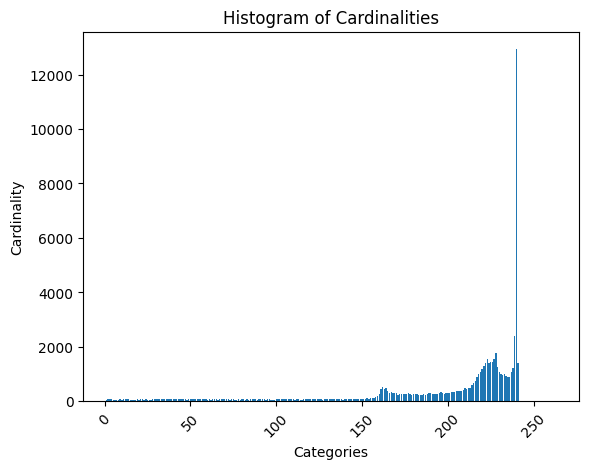

In [39]:
import matplotlib.pyplot as plt

# Sample dictionary

# Extract keys and values from the dictionary
categories = [x for x in sorted(s) if x ]
cardinalities = [s[x] for x in sorted(s) if x ]

# Plotting the histogram
plt.bar(categories, cardinalities)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Cardinality')
plt.title('Histogram of Cardinalities')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

## EXPERIMENTS

In [68]:
# TODO Base numeric representation

# Inspired by the LSTM paper

# For every column in given window calculate:
#
#   mean
#   std
#   skewness
#   kurtosis
#   min
#   quantiles (first, second and third)
#   max
#   deciles
#
# Returns: 
# Time stamp of the first record || IF TIMESTAMP flag is true
# 1D np.array float64 with measurements

In [88]:
def get_numeric_from_window(window, timestamp = False):
    measurements = []
    for sensor in window.columns:
        mean = window[sensor].mean()
        std = window[sensor].std()
        skewness = skew(window[sensor])
        kurt = kurtosis(window[sensor])
        quantiles = np.percentile(window[sensor], [0, 25, 50, 75, 100])
        deciles = np.percentile(window[sensor], range(10, 100, 10))
        # END OF CALCULATIONS
        sensor_measurements = np.concatenate(([mean, std, skewness, kurt], quantiles, deciles))
        measurements.append(sensor_measurements)

    if timestamp:
        return window.iloc[0].name, np.concatenate(measurements)
    return np.concatenate(measurements)


In [89]:
# Example usage of get_numeric_from_window
# It creates windows of length
START = pd.Timestamp('2012-04-15 08:23:47.763000') # Earlisest time stamp
END = pd.Timestamp('2014-01-31 19:27:10.884000') # Latest time stamp
FREQ = '3T'  # 3 minutes | must be argument for pd.Timedelta()
WINDOW_SIZE = '4T'  # 4minutes | must be argument for pd.Timedelta()

RESULTING_DATA = []

for win in extract_time_windows(DATA_369, WINDOW_SIZE, start=START, end=END, freq=FREQ):
    n = win.shape[0]
    if n < 20:
        continue
    RESULTING_DATA.append(get_numeric_from_window(win))

RESULTING_DATA = np.array(RESULTING_DATA)

/tmp/ipykernel_18471/3532504324.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(window[sensor])
/tmp/ipykernel_18471/3532504324.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(window[sensor])


In [91]:
RESULTING_DATA.shape

(72078, 180)

In [ ]:
# TODO Histogram representation

In [ ]:
# from risf.risf_data import RisfData
# from risf.distance import TrainDistanceMixin, SelectiveDistance # We will explain them later
# data = RisfData()

# categorical_feature = np.array([[0], [2], [1]])
# distances_categorical = [SelectiveDistance(projection_func = jaccard_projection, min_n=1, max_n=1)]
# data.add_data(categorical_feature, distances_categorical)

# numerical_features = np.random.randn(3, 3) # vector in R^3
# distances_numerical = [SelectiveDistance(projection_func = euclidean_projection, min_n=1, max_n=3),
#                         SelectiveDistance(projection_func = cosine_projection, min_n=1, max_n=3)]
# data.add_data(numerical_features, distances_numerical)

# set_features = np.array([{10, 20, 30}, {20, 30}, {10, 20}])
# distances_set = [TrainDistanceMixin(distance = jaccard_distance)]
# data.add_data(set_features, distances_set)

# graph_features = np.array([Graph(), Graph(), Graph()]) # Graph is just a dummy object
# distances_graph = [TrainDistanceMixin(distance = ipsen_mikailov), TrainDistanceMixin(distance = portrait)]
# data.add_data(graph_features, distances_graph)

In [ ]:
# from risf.forest import RandomIsolationSimilarityForest

# data = np.random.randn(100,10)
# forest = RandomIsolationSimilarityForest().fit(data)

In [ ]:
# forest = RandomIsolationSimilarityForest(distances = data.distances).fit(data)

In [ ]:
# TODO Remember about changing seed and keeping the seeds consistant
SEED = 23

In [ ]:
X = DATA_369['WetTankAirPressure'].values[:1000]
Y = DATA_369['WetTankAirPressure'].values[1000:2000]

In [ ]:
from risf.forest import RandomIsolationSimilarityForest

RISF = RandomIsolationSimilarityForest(random_state=SEED)

RISF.fit(X)

s = RISF.predict(Y, return_raw_scores=True)

In [ ]:
b = RISF.predict(Y)

In [ ]:
for i in range(0,len(b)):
    if b[i] == 1:
        print(s[i])

-0.006147078878442458
-0.01918464685061194
-0.01918464685061194
-0.006147078878442458
-0.006147078878442458
-0.006147078878442458
-0.006147078878442458
-0.01918464685061194
-0.04773895460027355
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.006147078878442458
-0.006147078878442458
-0.006147078878442458
-0.006147078878442458
-0.006147078878442458
-0.006147078878442458
-0.01918464685061194
-0.01918464685061194
-0.04773895460027355
-0.04773895460027355
-0.04773895460027355
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.006147078878442458
-0.006147078878442458
-0.006147078878442458
-0.006147078878442458
-0.006147078878442458
-0.006147078878442458
-0.01918464685061194
-0.04773895460027355
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.01918464685061194
-0.01918464685061